In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils_2 import ImageData, save_image_multiple, save_image
import sys
from PIL import Image

In [2]:
import time

In [5]:
IMG_DIM = 64
LATENT_DIM = 128
DISC_LATENT_DIM = 128
BATCH_SIZE = 128
GAMMA = 0.3
LAMDA = 0.001
OP_BETA = 0.9
OP_LR = 0.0001

In [6]:
def normalize_func(img):
    return (img-127.5)/127.5
def de_normalize_func(img):
    return ((img*127.5)+127.5).astype(np.int)

In [7]:
myImage = ImageData("D:/Jupyter/random dataset/image_dataset_small",20000,batch_size=BATCH_SIZE,resize=(IMG_DIM,IMG_DIM))
total_batches = myImage.total_batches
print("Total number of batches: ",total_batches)

Total number of batches:  157


(-0.5, 63.5, 63.5, -0.5)

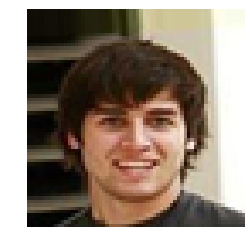

In [8]:
sample = myImage.get_sample_img()
plt.imshow(sample)
plt.axis('off')

In [9]:
tf.reset_default_graph()

In [10]:
x = tf.placeholder(tf.float32,shape=[None,IMG_DIM,IMG_DIM,3],name='input')
z = tf.placeholder(tf.float32,shape=[None,LATENT_DIM],name='latent')
kt = tf.placeholder(tf.float32,shape=[1],name='k_balance')

In [12]:
def generator(z):
    with tf.variable_scope("generator",reuse=tf.AUTO_REUSE):
        x = tf.layers.Dense(4*4*512)(z)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        x = tf.reshape(x,shape=[-1,4,4,512])
        
        x = tf.layers.Conv2DTranspose(512,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        
        x = tf.layers.Conv2DTranspose(256,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(256,kernel_size=2,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(128,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(128,kernel_size=2,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(64,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(3,kernel_size=2,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.tanh(x)
        return x

def discriminator(imgs):
    with tf.variable_scope("discriminator/encoder", reuse=tf.AUTO_REUSE):
        """ Block 1 """
        enc_in = tf.layers.Conv2D(filters=32,kernel_size=3,padding='same')(imgs)
        x = tf.layers.BatchNormalization()(enc_in)
        x = tf.nn.elu(x)
        
        
        x = tf.layers.Conv2D(filters=32,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        """ Block 2 """
        x = tf.layers.Conv2D(filters=64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(filters=64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        """ Block 3 """
        x = tf.layers.Conv2D(filters=128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(filters=128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        """ Block 4 """
        
        x = tf.layers.Conv2D(filters=256,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        x = tf.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        x = tf.layers.Flatten()(x)
        enc_out = tf.layers.Dense(DISC_LATENT_DIM,activation='linear')(x)
    
    with tf.variable_scope("discriminator/decoder",reuse=tf.AUTO_REUSE):
        dec_in = tf.layers.Dense(4*4*512)(enc_out)
        x = tf.layers.BatchNormalization()(dec_in)
        x = tf.nn.elu(x)
        x = tf.reshape(x,shape=[-1,4,4,512])
        
        x = tf.layers.Conv2DTranspose(512,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        
        x = tf.layers.Conv2DTranspose(256,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(256,kernel_size=2,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(128,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(128,kernel_size=2,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(64,kernel_size=2,strides=(2,2),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2DTranspose(3,kernel_size=2,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        dec_out = tf.nn.tanh(x)
        return dec_out

In [13]:
fake_img = generator(z)
real_decode = discriminator(x)
fake_decode = discriminator(fake_img)

decode_real_loss = tf.losses.absolute_difference(x,real_decode)
decode_fake_loss = tf.losses.absolute_difference(fake_img,fake_decode)

disc_loss = decode_real_loss - kt*decode_fake_loss
gen_loss = decode_fake_loss
kt_1 = kt + LAMDA * (GAMMA * decode_real_loss - decode_fake_loss)

convergence_measure = decode_real_loss + tf.abs(GAMMA * decode_real_loss - decode_fake_loss)

tf.add_to_collection('losses',convergence_measure)
generate_img_wrapper = tf.identity(fake_img,name="Generator")

In [14]:
gen_variable = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
dis_variable = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
gen_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in gen_variable])
dis_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in dis_variable])
print("gen_var_count:",gen_var_count)
print("dis_var_count:",dis_var_count)
print("total:",gen_var_count+dis_var_count)

gen_var_count: 3142345
dis_var_count: 4250345
total: 7392690


In [15]:
gen_op = tf.train.AdamOptimizer(OP_LR,beta1=OP_BETA)
gen_train = gen_op.minimize(gen_loss,var_list=gen_variable)

disc_op = tf.train.AdamOptimizer(OP_LR,beta1=OP_BETA)
disc_train = disc_op.minimize(disc_loss,var_list=dis_variable)

In [28]:
test_noise = np.random.uniform(-2,2,size=[36,LATENT_DIM])
test_sample = np.expand_dims(myImage.get_sample_img(normalize_func=normalize_func),0)

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
hist = []
#Initial k value
kt_temp = np.zeros(1)

In [19]:
whole_model_saver = tf.train.Saver(tf.global_variables())

# Total_gen_variable contain all the variable nessary to run inference
# which include Batch_norm variables that wasn't present in gen_varible (only trainable variable)
total_gen_variable = [v for v in tf.global_variables() if v.name.startswith('generator') and 'Adam' not in v.name]
generate_model_saver = tf.train.Saver(total_gen_variable)

In [32]:
start_time = time.time()
for i in range(101,501):
    start_epoch = time.time()
    for j in range (total_batches):
        batch = myImage.get_image(normalize_func=normalize_func)
        noises = np.random.uniform(-2,2,size=[BATCH_SIZE,LATENT_DIM])
        converge_val,kt_temp,_,__ = sess.run([convergence_measure,kt_1,gen_train,disc_train],
                                           feed_dict={x:batch,z:noises,kt:kt_temp})
        sys.stdout.write('\r Epoch {} ({}/{}): Loss = {}, kt = {}'.format(i,j,total_batches,converge_val,kt_temp))
        sys.stdout.flush()
        if (j % (total_batches//3) == 0):
            hist.append(converge_val)
    end_epoch = time.time()
    time_per_epoch = round(end_epoch-start_epoch)
    print('\r Epoch {}: Loss = {}                       {} secs'.format(i,converge_val,time_per_epoch))
    
    gen_imgs = sess.run(fake_img,feed_dict={z:test_noise})
    save_image_multiple('./export/BEGAN/generator_progress/',i,gen_imgs,de_normalize_func=de_normalize_func)
    
    dis_imgs = sess.run(real_decode,feed_dict={x:test_sample})
    save_image('./export/BEGAN/discriminator_progress/',i,dis_imgs[0],de_normalize_func=de_normalize_func)
    
    if (i % 5 == 0):
        whole_model_saver.save(sess,'./Model/BEGAN-Face/BEGAN_{}.ckpt'.format(i))
        generate_model_saver.save(sess,'./Model/BEGAN-Face/inference_model/BEGAN_generate_{}.ckpt'.format(i))
end_time = time.time()
print("Total training time: {} secs".format(round(end_time-start_time)))

 Epoch 101: Loss = 0.11053919047117233                       148 secs
 Epoch 102: Loss = 0.1112997978925705                       149 secs
 Epoch 103: Loss = 0.1033613383769989                       147 secs
 Epoch 104: Loss = 0.10093308240175247                       148 secs
 Epoch 105: Loss = 0.10026425868272781                       148 secs
 Epoch 106: Loss = 0.09872635453939438                       151 secs
 Epoch 107: Loss = 0.10005169361829758                       148 secs
 Epoch 108: Loss = 0.1004803255200386                       148 secs
 Epoch 109: Loss = 0.09947843849658966                       148 secs
 Epoch 110: Loss = 0.09912513196468353                       148 secs
 Epoch 111: Loss = 0.09879469871520996                       147 secs
 Epoch 112: Loss = 0.09975661337375641                       147 secs
 Epoch 113: Loss = 0.099680095911026                       148 secs
 Epoch 114: Loss = 0.09959740936756134                       147 secs
 Epoch 115: Loss = 0.0994

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

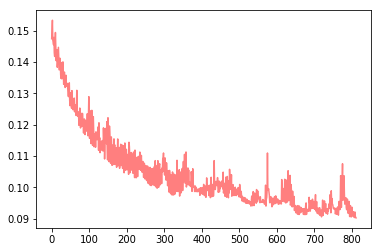

In [39]:
plt.plot(hist[50:],'r-',alpha=0.5)

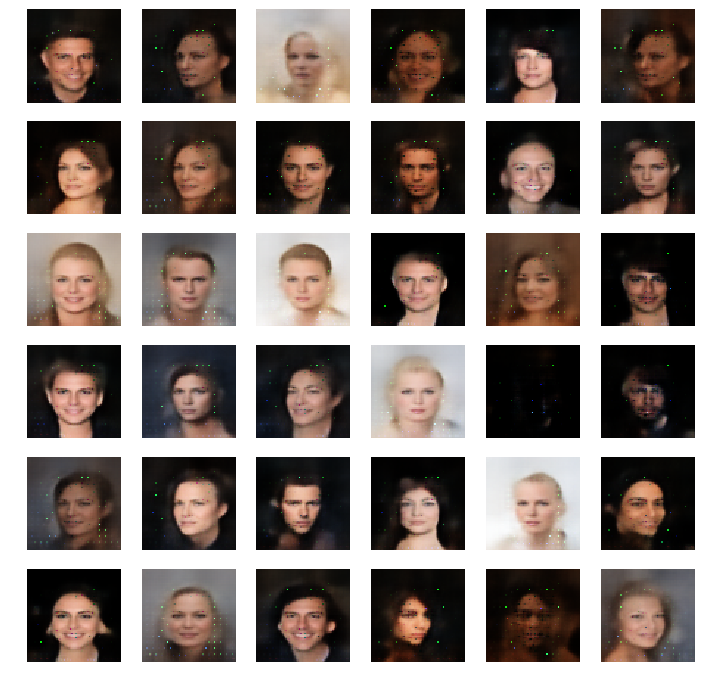

In [53]:
uniform_noise = np.random.uniform(1.,2,size=[36,LATENT_DIM])
gen_imgs = sess.run(fake_img,feed_dict={z:uniform_noise})
save_image_multiple('./export/BEGAN/generator_progress/',i,gen_imgs,show=True,de_normalize_func=de_normalize_func)
plt.close('all|')